# BATTLE OF THE CITIES versus Toronto
### Which US city is most like Toronto...?

In [85]:
import json
import numpy as np
import pandas as pd
import requests
import lxml.html
from bs4 import BeautifulSoup
!conda update -n base conda --yes

### if you get "failed with initial frozen solve" error then...
!conda create -n opencv --yes
!conda activate opencv --yes
!conda install -c conda-forge opencv --yes
### ...if you get "failed with initial frozen solve" error.

## sets up the environment to ensure that the Wiki can be scraped
!conda install -c conda-forge beautifulsoup4 --yes
!conda install -c conda-forge lxml --yes
!conda install -c conda-forge html5lib --yes
!conda install -c conda-forge requests --yes

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\ProgramData\Anaconda3

  added / updated specs:
    - conda


The following packages will be REMOVED:

  python_abi-3.8-1_cp38

The following packages will be SUPERSEDED by a higher-priority channel:

  altair                                        conda-forge --> pkgs/main
  conda              conda-forge::conda-4.9.2-py38haa244fe~ --> pkgs/main::conda-4.9.2-py38haa95532_0
  openssl                                       conda-forge --> pkgs/main


Preparing transaction: ...working... done
Verifying transaction: ...working... failed



EnvironmentNotWritableError: The current user does not have write permissions to the target environment.
  environment location: C:\ProgramData\Anaconda3


WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(139): Could not remove or rename C:\ProgramData\Anaconda3\envs\opencv\conda-meta\history.  Please remove this file manually (you may need to reboot to free file handles)

CondaValueError: prefix already exists: C:\ProgramData\Anaconda3\envs\opencv

activate does not accept more than one argument:
['opencv', '--yes']



Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



Due to the number of cities assessed, various efforts were made to retrieve the most amount of data possible without causing the services used to timeout. Persistence in pinging servers for repeated unreturned queries was kept to a minimum; and each city was limited to no more than 50 neighborhoods, pulled at random, as a representative sample. Repeat builds of the final form of the dataset are each unique but tend to yield very similar results.

# 1. Web-Scrape and create DataFrames for multiple cities...and strip each of them down to the same structure for the Functions and Foursquare that follows.

In [580]:
### pull TORONTO data
toronto_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
toronto_wiki = pd.read_html(toronto_url)
toronto_df = toronto_wiki[0]
toronto_df = toronto_df.rename(columns = {'Neighbourhood':'Neighborhood'})
toronto_df['Hood'] = toronto_df['Borough'] + ", " + toronto_df['Neighborhood']
toronto_df.drop(['Postal Code','Borough','Neighborhood'], axis=1, inplace=True)
toronto_df.rename(columns={'Hood':'Neighborhood'}, inplace=True)
#print(toronto_df.head(25))

### pull NEW YORK CITY data
nyc_url = "https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm#:~:text=ZIP%20Code%20Definitions%20of%20New%20York%20City%20Neighborhoods,10455%2C%2010459%2C%2010474%20%2033%20more%20rows%20"
newyorkcity_DOH = pd.read_html(nyc_url)
newyorkcity_df = newyorkcity_DOH[0]
newyorkcity_df['Hood'] = newyorkcity_df['Borough'] + ", " + newyorkcity_df['Neighborhood']
newyorkcity_df.drop(['ZIP Codes','Borough','Neighborhood'], axis=1, inplace=True)
newyorkcity_df.rename(columns={'Hood':'Neighborhood'}, inplace=True)
#print(newyorkcity_df.head(25))

### pull MIAMI data
miami_url = "https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Miami"
miami_wiki = pd.read_html(miami_url)
miami_df = miami_wiki[0]         #Coordinates dropped to rely on Foursquare later
miami_df.drop(columns=['Coordinates', 'Demonym','Population2010','Population/Km²','Sub-neighborhoods'], inplace=True)
#print(miami_df.head(25))

### pull CHICAGO data
chicago_url = "https://www.chicagotribune.com/chi-community-areas-htmlstory.html"
chicago_df = pd.read_html(chicago_url)[2]
chicago_df.rename(columns={0:'Neighborhood',1:'Community'}, inplace=True)   #chicago_df['Neighborhood'].iloc[row]
chicago_df['Hood'] = chicago_df['Neighborhood'] + ", " + chicago_df['Community']
chicago_df.drop(['Neighborhood', 'Community'], axis=1, inplace=True)
chicago_df.rename(columns={'Hood':'Neighborhood'}, inplace=True)
#print(chicago_df.head(25))

### pull LOS ANGELES data
la_url = requests.get("http://www.laalmanac.com/communications/cm02_communities.php")
la = la_url.content
losangeles_alma = pd.read_html(la)
losangeles_df = losangeles_alma[0]
losangeles_df.rename(columns={'City/Community':'Neighborhood'}, inplace=True)
losangeles_df.drop(['Zip Code(s)'], axis=1, inplace=True)
#print(losangeles_df.head(25)) 

# 2. A series of FUNCTIONS need to be defined that can each be performed on each city's dataframe...

### FUNCTION: ensures we only use rows with Borough and/or Neighborhood names assigned (i.e., drops 'Not assigned' rows)

In [88]:
## EXAMPLE Usage:  newcity_df = boroughsonly(original_df, 'County', "Not assigned")
def boroughsonly(citydata_df, boro_column, statement):
    rows = list(citydata_df.index)  #OR numboroughs = np.arange(1,toronto_df[['Borough']].shape[0])
    boro_df = pd.DataFrame(columns=citydata_df.keys())
    for row in rows:
        if (statement in citydata_df[[boro_column]].iloc[row,0])==False:
            boro_df.loc[len(boro_df.index)]   =   citydata_df.iloc[row].copy()
    return boro_df

### FUNCTION: names missing Neighborhoods the same as their corresponding Boroughs

In [89]:
## EXAMPLE Usage:  newcity_df = hoodnamedboro(original_df, 'Neighborhood', 'County', "Not assigned")
def hoodnamedboro(citydata_df, hood_column, boro_column, statement):
    nohood_inds = []
    inds = list(citydata_df.index)
    missinghoods  =  citydata_df[hood_column] == statement
    for i in inds:
        if missinghoods[i]==True:
            nohood_inds.append(i)
            citydata_df[hood_column][i]   =   citydata_df[boro_column][i].copy()
    #print(citydata_df.iloc[nohood_inds])   #verifies which rows, if any, that successfully had
    return citydata_df  #their missing Neighbourhood names changed to their corresponding Borough name

### FUNCTION: creates a Dictionary of the indices corresponding to each repeated Postal Code

In [90]:
## EXAMPLE Usage:  postal_dupes = rpc_indices(charlotte_df, 'Zip Code', 'Neighborhood')
def repeathoods(citydata_df, hood_column, cityname):
    i=0
    nother=0
    usedhoods = []
    rph_df = pd.DataFrame(columns=citydata_df.keys())
    hoods = list(citydata_df[hood_column].value_counts().index)
    for hood in hoods:  #given this particular Neighborhood...
        rph_df.loc[len(rph_df.index)] = citydata_df[ citydata_df[hood_column]==hood ].values[0][0]
        if citydata_df[hood_column].value_counts().loc[[hood]][0]>1   and   (hood in usedhoods)==False:
            #...if this Neighborhood has repeats elsewhere and has not been accounted for...
            usedhoods.append(hood)
            i+=1                   #(i.e., appends the key-value pair to dictionary rpc)
        elif citydata_df[hood_column].value_counts().loc[[hood]][0]==1:
            nother = nother + 1
            if nother==citydata_df.shape[0]:
                print("There are no repeated Neighborhoods in", cityname,". . .")
    return rph_df

### FUNCTION: separates all neighborhoods in each cell of the Neighborhood column into separate rows

In [91]:
## makes a list of unique Neighbourhood names (i.e., removes duplicates)
def unique_hoods(bloatedlist):
    ulist = []
    [ulist.append(str(hood)) for hood in bloatedlist if hood not in ulist]
    return ulist

## EXAMPLE Usage:  longmiami_df = sephoods(miami_df, 'Neighborhoods')
def sephoods(citydata_df, hood_column):
    i=0
    k=0
    seps_df = pd.DataFrame(columns=citydata_df.keys())
    for ind in citydata_df.index:
        bloatedlist = citydata_df[hood_column][ind]   #takes the list of 1 or more neighborhoods in the ind'th row
        hoods_list = unique_hoods(bloatedlist.split(", ")) #removes any repeat instances in a string
   
        for hood in hoods_list:  #taking this one Neighborhood at a time...
            seps_df.loc[len(seps_df.index)] = citydata_df.iloc[ind].copy()  #make the new df's new row the same
            seps_df[hood_column].iloc[-1] = hood  #change its Neighborhood to the one hood
        k=len(citydata_df.index)-1
        i+=1
    return seps_df

### FUNCTION: grabs some number of random Neighborhoods from each city (for each such sub-dataframe to later be concatenated into a single all-cities dataframe)
##### This is only done to cut down on runtime, given how massive some of the df's are, but can still be insightful as a mere exercise. Most curious is whether, for instance, ALL of Miami's 19 neighborhoods compared to only 50 out of Chicago's 203 neighborhoods will skew the results in any way.

In [92]:
def randomhoods(cityname, city_df, numberofhoods):
    import numpy
    import random
    rand_indices = random.sample(range(0, len(city_df)-1), numberofhoods)
                   #since it needs to be random, integer, and non-repeating
    rand_df = city_df.iloc[rand_indices].copy()
    rand_df['City'] = np.full((numberofhoods,), cityname)
    rand_df = rand_df[['City', 'Neighborhood']].reset_index(drop=True)
       #the city column is needed to discern the allcities_df rows later
       #the index is reset to ensure no conflict during concatenation
    return rand_df

### FUNCTION: loops to keep requesting for coordinates of each Neighborhood (or whichever such 'hood_column' you wish)

In [93]:
#first importing the necessary geospatial packages
#!conda install -c conda-forge geopy --yes
from geopy import geocoders
from geopy.geocoders import GoogleV3
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from pandas.io.json import json_normalize
#!conda install -c conda-forge folium=0.5.0 --yes

def getgeospatials(cityname, city_df, hood_column, agent, loopmax):
    geospatials = {}
    import math
    looplimit=0
    gh=None
    for hood in city_df[hood_column]:
        geolocator = Nominatim(user_agent=agent, timeout=10)
        while gh==None and looplimit!=loopmax:
            gh = geolocator.geocode('{}, {}'.format(hood, cityname))
            #gh = RateLimiter(geolocator.geocode('{}, {}'.format(hood, cityname)), min_delay_seconds=2)
            looplimit+=1
            
            if gh is None:
                geospatials[hood] = "no response"
            else:
                geospatials[hood] = [gh.latitude, gh.longitude]
                #print('{}, {}'.format(hood, cityname))
        looplimit=0
        gh=None
    return geospatials   #a dictionary pairing each Neighborhood with its corresponding lat,lng

### FUNCTION: removes rows of unfound geospatial coordinates

In [94]:
### attaches those geospatial coordinates to the Neighborhood dataframe

## EXAMPLE Usage:  geoscity_df = floatgeos_only(chicago_df, 'Neighborhood', 'hood.Latitude', 'hood.Longitude')
def realgeos_only(citydata_df, hood_geospatials, hood_column, hoodlat_column, hoodlng_column):
    #print(citydata_df)
    geo_df = citydata_df.copy()
    geo_df[hoodlat_column] = np.zeros( geo_df.shape[0] )
    geo_df[hoodlng_column] = np.zeros( geo_df.shape[0] )
    for row in geo_df.index:
        try:
            geo_df[hoodlat_column].loc[row] = float(hood_geospatials[geo_df[hood_column].iloc[row]][0])
            geo_df[hoodlng_column].loc[row] = float(hood_geospatials[geo_df[hood_column].iloc[row]][1])
        except:
            geo_df[hoodlat_column].loc[row] = "no info"
            geo_df[hoodlng_column].loc[row] = "no info"
    rows = list(geo_df.index)
    geo_df2 = pd.DataFrame(columns=geo_df.keys())
    for row in rows:
        if type(geo_df[hoodlat_column].iloc[row]) is float:
            geo_df2.loc[len(geo_df2.index)]   =   geo_df.iloc[row].copy()
    return geo_df2

# 3. Now let's use all of the functions defined so far to get an Expanded Geospatial version of a combined All-Cities DataFrame...

In [471]:
a=0
rands={}
num_rands = {'Toronto, Ontario':50, 'New York City, New York':19, 'Miami, Florida':19,
             'Chicago, Illinois':50, 'Los Angeles, California':50}
agents=['toronto_agent12', 'newyork_agent23', 'miami_agent34', 'chicago_agent45', 'losangeles_agent56']   #, 'losangeles_agent']
citydf_book = {'Toronto, Ontario':toronto_df, 'New York City, New York':newyorkcity_df,
               'Miami, Florida':miami_df, 'Chicago, Illinois':chicago_df, 'Los Angeles, California':losangeles_df}
for city,df in citydf_book.items():
    temp_df = df.copy()
    temp_df = boroughsonly(temp_df, 'Neighborhood', "Not assigned")
       #only returns rows that contain Neighborhood names
    temp_df = boroughsonly(temp_df, 'Neighborhood', "PO Boxes")  #yes, using the same function
       #only returns rows that are not just PO Boxes
    temp_df = sephoods(temp_df, 'Neighborhood')
       #splits up any multi-neighborhood rows into separate rows for each neighborhood
    temp_df = repeathoods(temp_df, 'Neighborhood', city)
       #returns the row indices of repeated Postal Codes

    rands[city] = randomhoods(city, temp_df, num_rands[city])    
       #chooses 18 random Neighborhoods to be representative of entire city
       #18 chosen only because Miami has that few, despite Chicago's 203

    temp_geospatials = getgeospatials(city, rands[city], 'Neighborhood', agents[a], 15)
    a+=1
       #with a separate Nominatim agent for each city
       #returns the geospatial coordinates of each neighborhood and concatenates them
    rands[city] = realgeos_only(rands[city], temp_geospatials, 'Neighborhood', 'hood:Latitude', 'hood:Longitude')
       #gets rid of any rows with unreturned geospatial coordinates
    print(rands[city].head(5))
    #print(city, "done!")
    citydf_book[city] = rands[city].copy()

allcities_df = pd.DataFrame(columns=rands[city].keys())
for   city, city_df   in   citydf_book.items():
    allcities_df = pd.concat([allcities_df, city_df], axis=0)
allcities_df['Neighborhood'] = allcities_df['Neighborhood'] + ", " + allcities_df['City']
allcities_df = allcities_df.drop(['City'], axis=1)
allcities_df
    

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


               City           Neighborhood  hood:Latitude  hood:Longitude
0  Toronto, Ontario  Humber Valley Village      43.666472      -79.524314
1  Toronto, Ontario               Sullivan      43.772680      -79.315945
2  Toronto, Ontario              Deer Park      43.688090      -79.394093
3  Toronto, Ontario    Lawrence Manor East      43.722079      -79.437507
4  Toronto, Ontario           Roncesvalles      43.651443      -79.451038


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


                      City              Neighborhood  hood:Latitude  \
0  New York City, New York                Mid-Island      40.879135   
1  New York City, New York  Stapleton and St. George      40.626477   
2  New York City, New York           Lower East Side      40.715936   
3  New York City, New York                  Flatbush      40.652048   
4  New York City, New York               Sunset Park      40.644337   

   hood:Longitude  
0      -72.940141  
1      -74.077636  
2      -73.986806  
3      -73.959027  
4      -74.007532  
There are no repeated Neighborhoods in Miami, Florida . . .


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


             City Neighborhood  hood:Latitude  hood:Longitude
0  Miami, Florida  Lummus Park      25.780613      -80.129893
1  Miami, Florida        Miami      25.774173      -80.193620
2  Miami, Florida     Downtown      25.818032      -80.335532
3  Miami, Florida    Park West      25.782475      -80.190664
4  Miami, Florida      Midtown      25.808225      -80.194429


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


                City     Neighborhood  hood:Latitude  hood:Longitude
0  Chicago, Illinois     Logan Square      41.928568      -87.706793
1  Chicago, Illinois           Loyola      42.001145      -87.661069
2  Chicago, Illinois  Near North Side      41.900033      -87.634497
3  Chicago, Illinois      Morgan Park      41.690312      -87.666716
4  Chicago, Illinois   Medical Center      41.875653      -87.673264


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


                      City                       Neighborhood  hood:Latitude  \
0  Los Angeles, California              Sunland (Los Angeles)      34.266947   
1  Los Angeles, California                           Palmdale      34.579313   
2  Los Angeles, California                   Hawaiian Gardens      33.828479   
3  Los Angeles, California  Los Angeles International Airport      33.942168   
4  Los Angeles, California                           Cerritos      33.864429   

   hood:Longitude  
0     -118.302300  
1     -118.117111  
2     -118.074314  
3     -118.421393  
4     -118.053932  


,Neighborhood,hood:Latitude,hood:Longitude
0,"Humber Valley Village, Toronto, Ontario",43.666472,-79.524314
1,"Sullivan, Toronto, Ontario",43.772680,-79.315945
2,"Deer Park, Toronto, Ontario",43.688090,-79.394093
3,"Lawrence Manor East, Toronto, Ontario",43.722079,-79.437507
4,"Roncesvalles, Toronto, Ontario",43.651443,-79.451038
...,...,...,...
35,"Malibu, Los Angeles, California",34.035591,-118.689423
36,"La Cañada Flintridge, Los Angeles, California",34.199830,-118.200524
37,"Commerce, Los Angeles, California",34.002581,-118.156586
38,"Littlerock, Los Angeles, California",34.521367,-117.987394


### FUNCTION: Extract venues categories and Foursquare-explore which are nearby...

In [472]:
CLIENT_ID = 'TNPJGNBMJOFGWKEXKU1KLF521U5C0FLS5CLLOZUFHFKJCE2I'
CLIENT_SECRET = 'S3KHF33J5KX2FN2N4ARYGTFLSVY2XIWCWNDTWOVWJNLBLSM1'
CODE = '2NCYL0DCHXHB3LDMLWNTABBE2JMS3QHAUD21JI2XBCURDGPV'
ACCESS_TOKEN = 'GMU0BZZFGOJYLCB0YLWEQS31X42VX2SQUQ31XKPN5UZCJSEH'
VERSION = '20210116'
LIMIT=100
RADIUS=500

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']  
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def getNearbyVenues(names, latitudes, longitudes, radius=100): 
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):  
        url = 'https://api.foursquare.com/v2/venues/explore?&v={}&oauth_token={}&ll={},{}&radius={}&limit={}'.format(
            VERSION, ACCESS_TOKEN, lat, lng, radius, LIMIT)   # create the API request URL
        results = requests.get(url).json()['response']['groups'][0]['items']   # make the GET request
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, lat, lng, 
            v['venue']['name'],   v['venue']['location']['lat'],   v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'])   for   v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 
                             'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    return(nearby_venues)

### FUNCTION: One-Hot Encodes the Dataframe via corresponding Venue Categories

In [473]:
def venueohed(cityvenues_df, hood_column):
    print('There are {} unique categories,'.format(len(cityvenues_df['Venue Category'].unique())), \
      '{} unique neighboorhoods,'.format(len(cityvenues_df[hood_column].unique())), \
      'and a massive {} unique venues.'.format(len(cityvenues_df['Venue'].unique())))
    ### applies OHE to the Venue Categories, assessed one Neighborhood at a time
    city_ohe = pd.get_dummies(cityvenues_df[['Venue Category']], prefix="", prefix_sep="|")
    city_ohe[hood_column] = cityvenues_df[hood_column] 
    fixed_columns = [city_ohe.columns[-1]] + list(city_ohe.columns[:-1])
    city_ohe = city_ohe[fixed_columns]

    city_grouped = city_ohe.groupby(hood_column).mean().reset_index()
    return city_grouped

### FUNCTION: sorts the popularity of those Venue Categories...

In [475]:
## a function that sorts the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

def sortvenuepop(city_grouped, num_top_venues, hood_column):
    ### creates a dataframe with the most common categories sorted
    indicators = ['st', 'nd', 'rd']
    columns = [hood_column]   #create columns according to number of top venues
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)   #empty dataframe with just the columns...
    neighborhoods_venues_sorted[hood_column] = city_grouped[hood_column]    #now with filled in Neighborhood column also
    for ind in np.arange(city_grouped.shape[0]):     #goes through the 40 observations/neighborhoods total
        neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)
        #each loop-iteration is a vertical numpy vector...which becomes each row of the resulting dataframe
    #print(neighborhoods_venues_sorted.shape)
    return neighborhoods_venues_sorted


## FUNCTION: KMEANS CLUSTERING according to each Neighborhood's most popular Venue Categories. Neighborhoods in the same cluster should have the most similar types of places near them.

In [476]:
def kmeans_city(city_grouped, kclusters, hood_column):
    city_grouped_clustering = city_grouped.drop(hood_column, 1)
    #toronto_grouped is the OHE dataframe of each neighborhood's venue type fingerprint
    kmeans = KMeans(init="k-means++", n_clusters=kclusters, random_state=0) \
             .fit(city_grouped_clustering)
    #print("The labels of the", len(city_grouped), "neighborhoods are: ", list(kmeans.labels_) )
    print("The",kclusters,"cluster centers have",city_grouped.shape[1],"dimensions each.")
    return kmeans

### FUNCTION: merges the main dataframes (Borough-Neighborhood and Popularity)

In [477]:
def mergegeopop(cityhoods_vensorted, city_df, hood_column, city_kmeans):
    cityhoods_vensorted.insert(0, 'Cluster Labels', city_kmeans.labels_)
      #add the new cluster labels to the dataframe
    city_merged = city_df.copy()
    city_merged = city_merged.join(cityhoods_vensorted.set_index(hood_column), on=hood_column)
      #merges the neighborhood geospatial data with the venue data and their clusters
    city_merged.reset_index(drop=True)

    import math
    inds=[]
    for ind in city_merged.index:
        #needed to rid any NaN rows that result from the merger above
        if math.isnan(city_merged['Cluster Labels'].iloc[ind])==True or  \
        math.isnan(city_merged['hood:Latitude'].iloc[ind])==True:
            inds.append(ind)
    city_merged = city_merged.drop(inds, axis=0)
    city_merged = city_merged.dropna()

    return city_merged.reset_index(drop=True)

## Now use the latest Functions to get the final form of the Dataframe...

In [579]:
cities_venues = getNearbyVenues(allcities_df['Neighborhood'],
                allcities_df['hood:Latitude'], allcities_df['hood:Longitude'] )
cities_grouped = venueohed(cities_venues, 'Neighborhood')
       #one-hot encodes the city based on its venue makeup (i.e., a code for each venue type)
cityhoods_vensorted = sortvenuepop(cities_grouped, 10, 'Neighborhood')
       #just has the Neighborhood column, then the 10 most popular in order
       #sorts the popularity of the venues for each neighborhood
cities_kmeans = kmeans_city(cities_grouped, 4, 'Neighborhood')
       #gets the kmeans clustering labels for the city passed to it
cities_merged = mergegeopop(cityhoods_vensorted, allcities_df, 'Neighborhood', cities_kmeans)
       #merges the two main dataframes, Borough info and Venue Popularity, into one
cities_merged = cities_merged[0:len(cities_merged)-1]
cities_grouped.head(15)

,Neighborhood,|ATM,|Accessories Store,|Adult Boutique,|African Restaurant,|Airport Lounge,|Airport Terminal,|American Restaurant,|Antique Shop,|Arcade,...,|Video Store,|Vietnamese Restaurant,|Waste Facility,|Weight Loss Center,|Wine Bar,|Wine Shop,|Women's Store,|Yoga Studio,|Zoo Exhibit,City
0,"Adelaide, Toronto, Ontario",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,Ontario
1,"Agincourt North, Toronto, Ontario",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,Ontario
2,"Andersonville, Chicago, Illinois",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.02381,0.0,Illinois
3,"Bassett, Los Angeles, California",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,California
4,"Bathurst Manor, Toronto, Ontario",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.034483,0.000000,0.00000,0.0,Ontario
5,"Bayview Village, Toronto, Ontario",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,Ontario
6,"Berczy Park, Toronto, Ontario",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,Ontario
7,"Beverly Woods, Chicago, Illinois",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,Illinois
8,"Brainerd, Chicago, Illinois",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,Illinois
9,"Brickell, Miami, Florida",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,Florida


# 4. In the map below, for all 5 cities (Toronto, New York, Chicago, Miami, and Los Angleles), a single cluster encompasses a very large majority of neighborhoods.
### This makes sense to me! We are only using Venue Categories as the metric essentially, and most neighborhoods throughout the country would be much the same, on paper. For instance, it's very typical that any given part of town has their share of restaurants, banks, gyms, bars, etc...especially when the radius used to define each neighborhood is more than just a few miles. While the specific makeup of venue types in the dataframe is technically unique for each Neighborhood, it's reasonable to me that the vectors would not be mathematically unique *enough* to consider the Neighborhoods much different from each other (even in a different city). Much of the unique character of each of these cities doesn't quite reveal itself from the choice of features.

### The algorithm used here may be sufficient to empirically assess the similarity between cities, but we have a limited set of features (i.e., the venue categories are not granular enough), and Nominatim/Foursquare both yield very limited results using a free acount (i.e., most neighborhood in all 5 cities was not retrievable, given the resources). Nonetheless, the results are not suprising, given the reasons stated above. (see map below)

In [575]:
import folium

geolocator = Nominatim(user_agent='foursquare-agent24')
usa_geo = geolocator.geocode('United States')
latitude = usa_geo.latitude
longitude = usa_geo.longitude

kclusters=4
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)   #creates map
x = np.arange(kclusters)   #set color scheme for the clusters, here and below
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, 2*len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []   #add markers to the map, here and below

i=0
for lat, lon, poi, cluster in zip(cities_merged['hood:Latitude'], cities_merged['hood:Longitude'], cities_merged['Neighborhood'], cities_merged['Cluster Labels']):
    i+=1
    
    cluster=int(cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters


### So given the overwhelming majority of Neighborhoods belonging to a single cluster, it may be the case that the hyper-dimensional data is shaped non-spherically and could benefit from DBSCAN instead of KMeans...

# 5. DBSCAN and tSNE Clustering

In [556]:
import math
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.5, min_samples=3).fit(cities_grouped.drop(['Neighborhood','City'], 1))
dblabels = db.labels_
print("The labels of the", len(cities_grouped.drop('Neighborhood', 1)), "neighborhoods are: ", list(dblabels) )
core_mask = np.zeros_like(dblabels, dtype=bool)
core_mask[db.core_sample_indices_] = True
n_clusters = len(set(dblabels)) - (1 if -1 in dblabels else 0)
unique_labels = set(dblabels)

cityhoods_vensorted_db = cityhoods_vensorted.drop('Cluster Labels', axis=1)
cityhoods_vensorted_db.insert(0, 'DBSCAN Clusters', db.labels_)
  #add the new cluster labels to the dataframe
cities_merged_db = allcities_df.copy()
cities_merged_db = cities_merged_db.join(cityhoods_vensorted_db.set_index('Neighborhood'), on='Neighborhood')
  #merges the neighborhood geospatial data with the venue data and their clusters

inds=[]
for ind in cities_merged_db.index:
#needed to rid any NaN rows that result from the merger above; see Markdown note below
    if math.isnan(cities_merged_db['DBSCAN Clusters'].iloc[ind])==True:
        inds.append(ind)

cities_merged_db = cities_merged_db.drop(inds)
cities_merged_db = cities_merged_db.dropna()
cities_merged_db = cities_merged_db.reset_index(drop=True)
cities_merged_db = cities_merged_db[0:len(cities_merged_db)-1]
cities_merged_db.head()

The labels of the 130 neighborhoods are:  [0, -1, 0, 0, 0, -1, 0, -1, 1, 0, 0, -1, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, -1, 0, -1, -1, 0, 0, 0, 0, 0, -1, -1, -1, 0, 0, -1, 0, 0, 0, 0, 0, -1, -1, -1, 0, -1, -1, -1, 0, -1, 0, -1, -1, -1, -1, -1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0, 1, 0, 0, -1, -1, 0, -1, 0, -1, 0, -1, -1, 0, 0, -1, -1, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, -1, 0, 0, 0, 0, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, -1, 0, 1, 0, 0]


,Neighborhood,hood:Latitude,hood:Longitude,DBSCAN Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Humber Valley Village, Toronto, Ontario",43.666472,-79.524314,-1.0,|Home Service,|Zoo Exhibit,|Financial or Legal Service,|Ethiopian Restaurant,|Eye Doctor,|Falafel Restaurant,|Farmers Market,|Fast Food Restaurant,|Film Studio,|Fire Station
1,"Deer Park, Toronto, Ontario",43.688090,-79.394093,0.0,|Coffee Shop,|Bank,|Pharmacy,|Pizza Place,|Bagel Shop,|Grocery Store,|Shoe Store,|Sandwich Place,|Juice Bar,|ATM
2,"Lawrence Manor East, Toronto, Ontario",43.722079,-79.437507,-1.0,|Art Gallery,|Zoo Exhibit,|Dumpling Restaurant,|Ethiopian Restaurant,|Eye Doctor,|Falafel Restaurant,|Farmers Market,|Fast Food Restaurant,|Film Studio,|Financial or Legal Service
3,"Roncesvalles, Toronto, Ontario",43.651443,-79.451038,0.0,|Boutique,|Gift Shop,|Pub,|Bookstore,|Movie Theater,|Cambodian Restaurant,|Candy Store,|Bar,|Bank,|Restaurant
4,"Grange Park, Toronto, Ontario",43.652197,-79.392319,0.0,|Art Gallery,|Café,|College Gym,|Park,|Zoo Exhibit,|Eye Doctor,|Falafel Restaurant,|Farmers Market,|Fast Food Restaurant,|Film Studio


In [568]:
map_clusters = folium.Map(location=[latitude, longitude], tiles='cartodbdark_matter', zoom_start=4)   #creates map
Dclusters = len(unique_labels)
x = np.arange(Dclusters)   #set color scheme for the DBSCAN clusters, here and below
ys = [i + x + (i*x)**2 for i in range(Dclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, 2*len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []   #add markers to the map, here and below

db_legend = {}
for lat, lon, poi, cluster in zip(cities_merged_db['hood:Latitude'], cities_merged_db['hood:Longitude'], cities_merged_db['Neighborhood'], cities_merged_db['DBSCAN Clusters']):
    cluster=int(cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
    db_legend[cluster] = rainbow[cluster-1]
print(db_legend)
map_clusters

{-1: '#ff964f', 0: '#ff0000', 1: '#8000ff'}


### ...but despite taking non-spherically of the data into account, we still essentially assess that most neighborhoods across the map are much the same, given the data. The red dots are for Cluster 0, and the purple dots as Cluster -1 (note this is not the same as KMeans' cluster numbers), with the -1 cluster representing outliers that have no significant place in any given non-spherical cluster. Adjusting the DBSCAN's epsilon and sample minimum can present alternative arrangements ranging from almost-all red to almost-all purple, hence almost all of the same cluster or almost all considered outliers, respectively.

## A look at tSNE Dimensionality Reduction (of all cities combined) is a way for us to visualize the inherent clustering of datapoints in 2D, regardless of label assignment or the original number of dimensions.
#### The intent here is to provide some further corroboration to our observations above (i.e., that neighborhoods throughout all 5 cities aren't that distinguishable from one another)... As can be seen by this tSNE plot, the colors' (hence the cities' venue characteristics) overlap with one another is just enough to where no distinct clusters can be made out. This *confirms* just how nearly single-clustered both KMeans and DBSCAN turned out, no matter how much their hyperparameters were tweaked. Again, it's reasonable that merely a few neighborhoods sampled at random would be much the same, in terms of venue categories alone, given the information available. A more feature-rich and/or more geographically inclusive dataset would likely reveal a much more class-balanced map. The algorithms presented here only ended up having 122 neighborhoods available across all 5 cities, which is miniscule given the 250+ one-hot encoded features. Having fewer observations than features may be the sole culprit of the data being largely noisy.

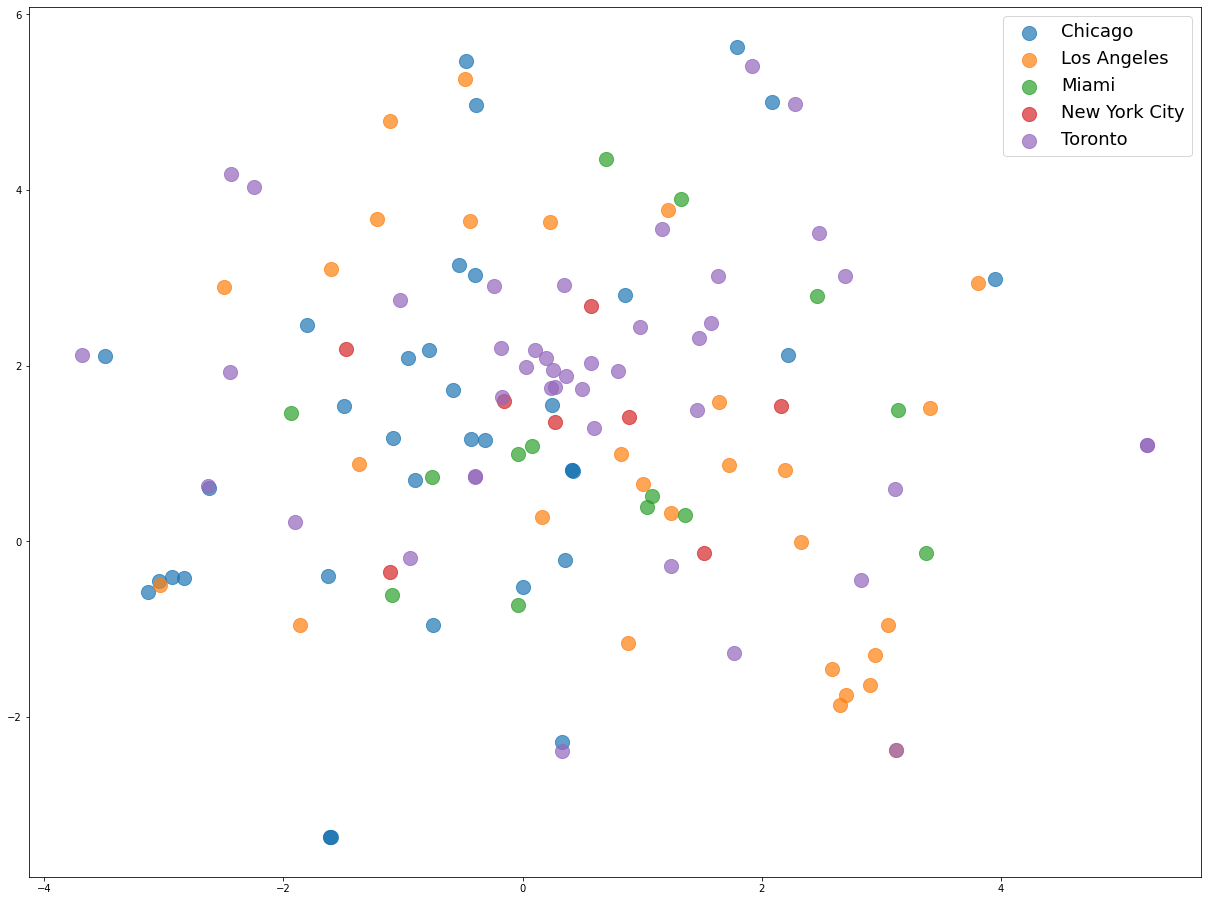

In [509]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn import (manifold, datasets, decomposition, ensemble, discriminant_analysis, random_projection)
from sklearn.manifold import TSNE

#grabs just the name of the State the neighborhood is from
def pullcity(hood):
    hood = hood.split(",", 2)[-2].replace(" ", "", 1)
    return hood
#cities_grouped['Neighborhood'].apply(pullcity)

from sklearn.preprocessing import LabelEncoder
statecolors = LabelEncoder().fit_transform( cities_grouped['Neighborhood'].apply(pullcity) )

#clusters the data via tSNE, with colors corresponding to each State (hence the corresponding City)
temp_df = cities_grouped.copy()
temp_df = temp_df.drop(['Neighborhood'], 1)
X = pd.DataFrame( TSNE(n_components=2).fit_transform(temp_df) )
X['City'] = cities_grouped['Neighborhood'].apply(pullcity)
  
fig,ax = plt.subplots(figsize=(21,16))
for k,x in X.groupby('City'):
    ax.scatter(x[0], x[1], label=k, s=200, alpha=0.7)
plt.legend(loc=1, fontsize=18)
plt.show()

# 6. FINAL POINT (Cosine Similarity to Toronto)
### Perhaps the most comprehensive metric of a city's "venue profile" is a single vector containing that city's average, neighborhood venue frequencies...

In [513]:
temp_df = cities_grouped
def pullstate(hood):
    hood = hood.split(",", 2)[-1].replace(" ", "", 1)
    return hood
temp_df['City'] = temp_df['Neighborhood'].apply(pullstate)
tempgroup_df = temp_df.groupby(by='City').mean()
tempgroup_df = tempgroup_df.rename(index={'California': 'Los Angeles', 'Florida':'Miami', 'Illinois':'Chicago', 'Ontario':'Toronto'})
tempgroup_df

,|ATM,|Accessories Store,|Adult Boutique,|African Restaurant,|Airport Lounge,|Airport Terminal,|American Restaurant,|Antique Shop,|Arcade,|Art Gallery,...,|Vegetarian / Vegan Restaurant,|Video Store,|Vietnamese Restaurant,|Waste Facility,|Weight Loss Center,|Wine Bar,|Wine Shop,|Women's Store,|Yoga Studio,|Zoo Exhibit
City,,,,,,,,,,,,,,,,,,,,,
Los Angeles,0.006286,0.008621,0.000539,0.000000,0.000000,0.000000,0.012033,0.000000,0.000000,0.000000,...,0.000000,0.001567,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006082,0.000
Miami,0.000000,0.000928,0.000000,0.000000,0.000000,0.000000,0.007421,0.000000,0.000928,0.002783,...,0.005009,0.000928,0.000928,0.000000,0.000928,0.002968,0.000000,0.003896,0.000000,0.000
Chicago,0.000000,0.000000,0.000000,0.000000,0.006944,0.006944,0.033889,0.001323,0.000000,0.008929,...,0.000000,0.001323,0.000000,0.000556,0.000000,0.001323,0.001111,0.005208,0.001217,0.000
New York,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038889,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005435,0.000000,0.000000,0.125
Toronto,0.002327,0.000423,0.000000,0.002114,0.000000,0.000000,0.001201,0.000000,0.000000,0.054440,...,0.000930,0.002114,0.003797,0.000000,0.000000,0.000629,0.002170,0.000846,0.001159,0.000


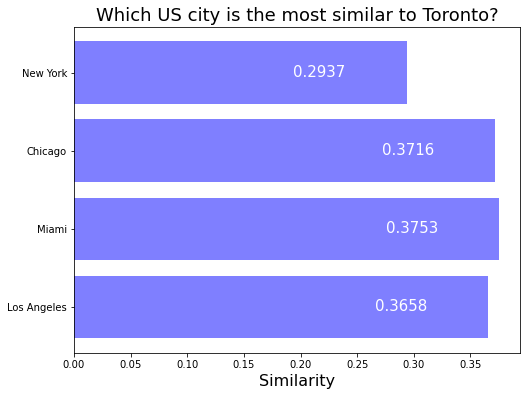

In [521]:
venue_vects = {}
city_sims = {}
from numpy import linalg
for town in tempgroup_df.index:
    venue_vects[town] = tempgroup_df.loc[town].to_numpy()
for town in tempgroup_df.index:
    city_sims[town] = np.dot(venue_vects[town], venue_vects['Toronto']) / \
                             np.linalg.norm(venue_vects[town]) / \
                             np.linalg.norm(venue_vects['Toronto'])
sims_df = pd.DataFrame(list(city_sims.items()),columns = ['City','Similarity to Toronto']) 
sims_df = sims_df[0:len(sims_df)-1]

i=0
fig,ax = plt.subplots(figsize=(8,6))
ax.barh(sims_df['City'], sims_df['Similarity to Toronto'], align='center', alpha=0.5, color='b')
for sim in sims_df['Similarity to Toronto']:
    ax.text(sim-0.10,i-0.05, str(np.around(sim,4)), color='white', fontsize=15)
    i+=1
ax.set(yticks=sims_df['City'], yticklabels=sims_df['City'])
plt.xlabel('Similarity', fontsize=16)
plt.title('Which US city is the most similar to Toronto?', fontsize=18)
plt.show()



## *So as we can see here, three of the cities are almost equally similar to Toronto, and New York's similarity to Toronto isn't that far off from the others.* With this single metric, we're given a number that further confirms why tSNE Clustering visualized so much overlap, and why both KMeans and DBSCAN failed to discern much more than a single cluster amongst all of the data. That is, an essentially random sample of neighborhoods from any given city likely consists of roughly the same variety of places. Further exploration via a larger dataset would be needed to uncover significant differences.